<a href="https://colab.research.google.com/github/amitmakashir/Deep-learning/blob/master/Part2_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow.contrib import rnn
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import math
import pandas
import pickle
import seaborn as sns

sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive/Deep Learning/Hw3"

audiofiles.pickle	      homework3.zip    train_audiofiles.pickle
audiofiles_validation.pickle  test_output.zip  validation_audiofiles.pickle


In [0]:
!cp "/content/drive/My Drive/Deep Learning/Hw3/homework3.zip" "hw3.zip"

In [0]:
!unzip "hw3.zip"

#### Uncomment the following 4 blocks of code if you want to process the audio files from scratch, otherwise the files will be loaded from pickles stored in google drive.
Convert all the training and vaildation audio files to a matrix using STFT. We store both the complex valued output  of the STFT (org) and the magnitude of these values in (abs) . 

In [0]:
# training_files = {"abs":{"s":[],"n":[],"x":[]},"org":{"s":[],"n":[],"x":[]}}

# for i in range(1200):
#     if i%100 == 0:
#         print(i)
        
#     file_no = str(1000000 + i)[-4:]
    
#     for audio_type in ["s","n","x"]:
#         file_name = "timit-homework/tr/"+"tr"+audio_type+file_no+".wav"
#         s, sr = librosa.load(file_name, sr=None)
#         S = librosa.stft(s, n_fft=1024, hop_length=512)
#         training_files["org"][audio_type].append(S.T) # S.shape => (x, 513)
        
#         S_mod = np.abs(S.T) # S_mod.shape => (x, 513)
#         training_files["abs"][audio_type].append(S_mod)

In [0]:
# # Store data in a pickle file
# with open('train_audiofiles.pickle', 'wb') as handle:
#     pickle.dump(training_files, handle)
    
# # Copy the pickle file to Drive for backup purposes
# !cp "train_audiofiles.pickle" "/content/drive/My Drive/Deep Learning/Hw3/train_audiofiles.pickle"

In [0]:
# validation_files = {"abs":{"s":[],"n":[],"x":[]},"org":{"s":[],"n":[],"x":[]}}

# for i in range(1200):
#     if i%10 == 0:
#         print(i)
    
#     file_no = str(1000000 + i)[-4:]
    
#     for audio_type in ["s","n","x"]:
#         file_name = "timit-homework/v/"+"v"+audio_type+file_no+".wav"
#         s, sr = librosa.load(file_name, sr=None)
#         S = librosa.stft(s, n_fft=1024, hop_length=512)
         
#         validation_files["org"][audio_type].append(S.T) # S.shape => (x, 513)
        
#         S_mod = np.abs(S.T) # S_mod.shape => (x, 513)
#         validation_files["abs"][audio_type].append(S_mod)

In [0]:
# # Store data in a pickle file
# with open('validation_audiofiles.pickle', 'wb') as handle:
#     pickle.dump(validation_files, handle)

# # Copy the pickle file to Drive for backup purposes
# !cp "validation_audiofiles.pickle" "/content/drive/My Drive/Deep Learning/Hw3/validation_audiofiles.pickle"

#### All the above steps were to process the audio files and store it into a pickle file. This will save our time required to upload these files and process them every time we want to execute this code.

In [0]:
!cp "/content/drive/My Drive/Deep Learning/Hw3/train_audiofiles.pickle" "train_audiofiles.pickle"
!cp "/content/drive/My Drive/Deep Learning/Hw3/validation_audiofiles.pickle" "validation_audiofiles.pickle"

# Load data from the pickle file
with open('train_audiofiles.pickle', 'rb') as handle:
    training_files = pickle.load(handle)
    
with open('validation_audiofiles.pickle', 'rb') as handle:
    validation_files = pickle.load(handle)

In [0]:
# Training IBMs
train_ibm = [(training_files["abs"]["s"][i] > training_files["abs"]["n"][i])*1 for i in range(1200)]
val_ibm = [(validation_files["abs"]["s"][i] > validation_files["abs"]["n"][i])*1 for i in range(1200)]

In [0]:
class miniBatch():
    '''
    Create mini Batches of the data for training the model
    In our case, we are making the default batch size as 10
    The reason being, 10 continous audio files have same dimensions
    For eg: the first 10 audio files have the dimension 65x513
    
    This helps in creating a 3D tensor (For eg: 10x65x513)
    
    '''
    def __init__(self,x,s,batch_size=10):
        self.x = x
        self.s = s

        self.rows = len(x)
        self.batch_size = batch_size
        self.curr_index = 0

        # Total number of iterations
        self.iters = math.ceil(self.rows/self.batch_size)
        pass


    def nextBatch(self):
        '''
        Return the next batch of data
        If the last batch is not of the batch size, give all the remaining elements
        '''

        if self.curr_index + self.batch_size >= self.rows:
            batch_x = self.x[self.curr_index:]
            batch_y = self.s[self.curr_index:]
        else:
            batch_x = self.x[self.curr_index:self.curr_index+self.batch_size]
            batch_y = self.s[self.curr_index:self.curr_index+self.batch_size]

        self.curr_index = self.curr_index+self.batch_size
        return np.array(batch_x),np.array(batch_y)


    
def crossValSet(x,y,size):
    '''
    Size will be in percent
    Remove "size"% of data from the last as keep it for CV  
    '''
    no_of_elements = math.ceil(len(x)*(size/100))

    train_x = x[:-no_of_elements]
    train_y = y[:-no_of_elements]

    cv_x = x[-no_of_elements:]
    cv_y = y[-no_of_elements:]    
    return train_x,train_y,cv_x,cv_y


def calcSNR(s_pred_td,s_true_td):
    '''
    If the length of the two spectrograms is not equal, slice them with the 
    minimum of the two. 
    SNR = 10*log10(signal/noise)
    '''
    if s_pred_td.shape[0] != s_true_td.shape[0]:
        min_length = min(s_pred_td.shape[0],s_true_td.shape[0])
        s_pred_td = s_pred_td[:min_length]
        s_true_td = s_true_td[:min_length]

    signal = np.sum(np.square(s_true_td))
    noise = np.sum(np.square(s_true_td - s_pred_td))

    snr = 10 * np.log10(signal/noise)

    return snr


def feedForward(X):
    m_output = []
    
    # Run a feedforward on the validation data
    for i in range(len(X)):
        input_x = X[i].reshape(1,-1,513)
        network_output = sess.run(y_pred, feed_dict={x: input_x})
        m_output.append(network_output.reshape(-1,513))
    return m_output


def getLoss(X,y):
    # Run a feedforward to get the loss of the objective function
    error = 0
    mini_batch = miniBatch(X,y)
    
    for iter in range(mini_batch.iters):
        batch_x,batch_y = mini_batch.nextBatch()
        error += sess.run(loss, feed_dict={x: batch_x, y_true: batch_y}) 
    return error


def transform_input(x):
    return x.reshape((1,-1,513))

def reverse_transform(x):
    return x.reshape((-1,513))

In [0]:
# hidden LSTM units
hidden_units = 513

# learning rate for AdamOptimizer
learning_rate = 0.001

# Hyperparamters for the network
epochs = 50

In [0]:
tf.reset_default_graph()

# Create placeholders for input X and labels y
x = tf.placeholder(tf.float32, [None,None,513])
y_true = tf.placeholder(tf.float32, [None,None,513])

# defining the network   
lstm_cell = tf.contrib.rnn.LSTMCell(num_units = hidden_units,
                                    initializer = tf.contrib.layers.variance_scaling_initializer())
    
lstm_dropout = tf.contrib.rnn.DropoutWrapper(lstm_cell,
                                             input_keep_prob=0.95, 
                                             output_keep_prob=0.95)

lstm_layers = tf.contrib.rnn.MultiRNNCell([lstm_dropout])


network_output, state = tf.nn.dynamic_rnn(cell = lstm_layers,
                                          inputs = x,
                                          dtype="float32")


# converting last output of dimension [batch_size,num_units] to [batch_size,n_classes] by out_weight multiplication
y_pred = tf.layers.dense(inputs = network_output, 
                         units = 513, 
                         kernel_initializer = tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.sigmoid,
                         bias_initializer = tf.zeros_initializer())


# loss_function
loss = tf.losses.mean_squared_error(y_pred, y_true)

# optimization
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

### Start the session
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()


# Training data and labels for validation
val_x = validation_files["abs"]["x"]  # shape => (1200,x,513)
val_y = val_ibm  # shape => (1200,x,513)

# Test the model on validation files after each epoch
cv_errors = []

# ====== Training the network ======  
for e in range(epochs):
    # Create minibatches and train data on it
    train_x = training_files["abs"]["x"]
    train_m = train_ibm
    mini_batch = miniBatch(train_x,train_m)
    
    for iter in range(mini_batch.iters):
        batch_x,batch_y = mini_batch.nextBatch()
        sess.run(train_step, feed_dict={x: batch_x, y_true: batch_y})
    
    if e%5==0:
        cv_errors.append(getLoss(val_x,val_y))

In [0]:
m_output = feedForward(val_x) # shape => (1200,x,513)
    
# Thresholding the m_output at 0.5
m_output = [(m_output[i]>=0.5)*1 for i in range(len(m_output))]

In [0]:
# Calculated mean SNR for all the validation files
def convertToaudio(masks,X,test=False):
    '''
    We calculated the M matrix for the dirty noise. The M matrix is "Ideal binary
    masks".
    
    IBM assumes that at each of the time-frequency bin at (f,t) in our X matrix
    is either noise or speech(clean). It generates a matrix with same dimensions 
    as X that has 1 or 0 in it. (0 meaning noise)
    
    After taking element wise product of X and M, all the points that had IBM 0 
    would be deactivated and we would only have clean speech
    '''
    assert(len(masks) == len(X))
    istft_output = []
    
    for i in range(len(X)):
        output = masks[i] * X[i]
        istft = librosa.istft(output.T, hop_length=512, win_length=1024)
        istft_output.append(istft)
        
        file_no = str(1000000 + i)[-4:]
        
        if test:
            librosa.output.write_wav('Test_output/tes_'+file_no+'.wav', istft, sr=16000)
        else:
            librosa.output.write_wav('validation_'+str(i)+'.wav', istft, sr=16000)    
    
    return istft_output


In [0]:
istft_output = convertToaudio(m_output,validation_files["org"]["x"])

In [0]:
def meanSNR(recovered_audio):
    '''
    To calculate the mean SNR for all the validation files, we require the ground
    truth label of the clean source for all these files.
    Now, because the 
    '''
    snrs = []
    for i in range(len(recovered_audio)):
        if i%10 == 0:
            file_no = str(1000000 + i)[-4:]
            file_name = "timit-homework/v/"+"vs"+file_no+".wav"
            s, sr = librosa.load(file_name, sr=None)

        snrs.append(calcSNR(recovered_audio[i],s))

    return np.mean(snrs),snrs

mean_snr,snrs = meanSNR(istft_output)
print("The mean SNR for all the validation files is: "+str(round(mean_snr,2)))

The mean SNR for all the validation files is: 10.38


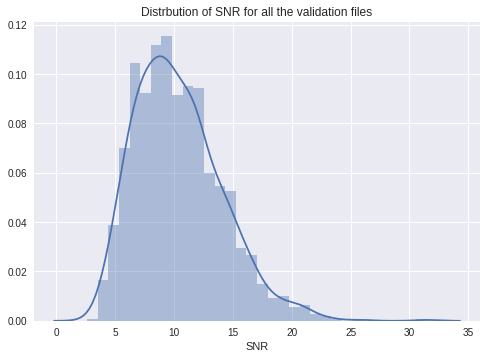

In [0]:
histogram = sns.distplot(snrs)
histogram.set_title("Distrbution of SNR for all the validation files")
histogram.set_xlabel("SNR")
plt.show()

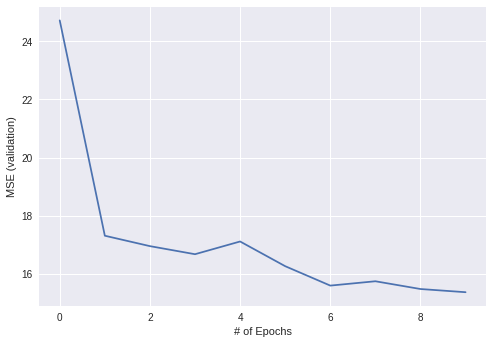

Mean squared error for the last iteration (on Validation set): 15.36


In [0]:
def error_plot(errors):
    plt.plot(errors)
    plt.ylabel("MSE (validation)")
    plt.xlabel("# of Epochs")
    plt.show()

    return errors[-1]

error_plot(cv_errors)
print("Mean squared error for the last iteration (on Validation set): " + str(round(cv_errors[-1],3)))  

## Testing the network

Now that we have trained our model and are satisfied with the results on validation set. We'll move onto the testing phase.

We are given 400 test files on which our network would be tested. We'll start by loading these files and processing them.


In [0]:
test_files = {"abs":{"x":[]},"org":{"x":[]}}

for i in range(400):
    file_no = str(1000000 + i)[-4:]
    
    file_name = "timit-homework/te/"+"tex"+file_no+".wav"
    s, sr = librosa.load(file_name, sr=None)
    S = librosa.stft(s, n_fft=1024, hop_length=512)
    test_files["org"]["x"].append(S.T) # S.shape => (x, 513)

    S_mod = np.abs(S.T) # S_mod.shape => (x, 513)
    test_files["abs"]["x"].append(S_mod)

In [0]:
test_x = test_files["abs"]["x"]
masks_test = feedForward(test_x) # shape => (400,x,513)
    
# Thresholding the m_output at 0.5
masks_test = [(masks_test[i]>=0.5)*1 for i in range(len(masks_test))]

In [0]:
!mkdir "Test_output"

In [0]:
istft_output_test = convertToaudio(masks_test,test_files["org"]["x"],test=True)

In [0]:
!zip -r "test_output.zip" "Test_output"
!cp "test_output.zip" "/content/drive/My Drive/Deep Learning/Hw3/"

In [0]:
sess.close()